In [152]:
%cd loqui
! git checkout main && git pull origin main

!pip install -r requirements.txt

[Errno 2] No such file or directory: 'loqui'
/tf/loqui
Already on 'main'
Your branch is up to date with 'origin/main'.
From https://github.com/aviadshimoni/loqui
 * branch            main       -> FETCH_HEAD
Already up to date.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [153]:
!cat requirements.txt
!pip install face_alignment
!pip install dlib

torch >= 1.3.0
numpy >= 1.16.4
opencv-python >= 4.1.0
PyTurboJPEG
matplotlib~=3.7.1Requirement already satisfied: face_alignment in /usr/local/lib/python3.8/dist-packages (1.3.5)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [154]:
import torch
import cv2
import numpy as np

In [155]:
def get_frame_sizes(file_name: str) -> list:
    """
    Gets a path to an MP4 video file and returns the size (dimensions) of each frame.
    :param file_name: Path to the MP4 video file.
    :return: List of frame sizes in the given video file.
    """
    cap = cv2.VideoCapture(file_name)
    frame_sizes = []

    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame_sizes.append(frame.shape[:2])  # Get width and height of the frame
        else:
            break

    cap.release()

    return frame_sizes

file_name = "/tf/single-videos/FRENCH_00002.mp4"
sizes = get_frame_sizes(file_name)
for size in sizes:
    print(size)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [156]:
from turbojpeg import TurboJPEG
import math
jpeg = TurboJPEG()


def extract_opencv(file_name: str) -> list:
    """
    Gets a path to a video file, resizes frames to 256x256, and tries to extract the ROI from it.
    :param file_name: Path to the video file.
    :return: ROI of the given video file.
    """

    video = []
    cap = cv2.VideoCapture(file_name)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("length", length)

    while cap.isOpened():
        ret, frame = cap.read()  # BGR
        if ret:
            # resized_frame = cv2.resize(frame, (256, 256))
            # roi = resized_frame[115:211, 79:175]

            video.append(frame)
        else:
            break
    cap.release()

    return video

# def extract_opencv(file_name: str) -> list:
#     """
#     Gets a path to a video file and tries to extract the ROI from it.
#     :param file_name: Path to the video file.
#     :return: ROI of the given video file.
#     """
#     detector = dlib.get_frontal_face_detector()
#     predictor = dlib.shape_predictor("/tf/loqui/shape_predictor_68_face_landmarks.dat")
#     video = []
#     cap = cv2.VideoCapture(file_name)

#     while cap.isOpened():
#         ret, frame = cap.read()  # BGR
#         if ret:
#             gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#             faces = detector(gray)
#             for face in faces:
#                 landmarks = predictor(gray, face)
#                 # Define the region of interest (ROI) based on facial landmarks
#                 min_x = min(landmarks.part(i).x for i in range(0, 68))
#                 max_x = max(landmarks.part(i).x for i in range(0, 68))
#                 min_y = min(landmarks.part(i).y for i in range(0, 68))
#                 max_y = max(landmarks.part(i).y for i in range(0, 68))
                
#                 # Adjust the ROI boundaries to make it smaller
#                 offset = 26
#                 min_x += offset - 10
#                 max_x -= offset
#                 min_y += offset
#                 max_y -= offset
                
#                 roi = frame[min_y:max_y, min_x:max_x]
#                 video.append(roi)
#         else:
#             break
#     cap.release()

#     return video



In [157]:
import os
import face_alignment
import time
import cv2
import numpy as np
from multiprocessing import Pool, Process, Queue
import time
import os

def get_faces(frames):
    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device='cuda')
    all_landmarks = []
    for frame in frames:
        points_list = fa.get_landmarks(frame)
        all_landmarks.append(points_list)

    return  all_landmarks


def get_position(size, padding=0.25):

    x = [0.000213256, 0.0752622, 0.18113, 0.29077, 0.393397, 0.586856, 0.689483, 0.799124,
                    0.904991, 0.98004, 0.490127, 0.490127, 0.490127, 0.490127, 0.36688, 0.426036,
                    0.490127, 0.554217, 0.613373, 0.121737, 0.187122, 0.265825, 0.334606, 0.260918,
                    0.182743, 0.645647, 0.714428, 0.793132, 0.858516, 0.79751, 0.719335, 0.254149,
                    0.340985, 0.428858, 0.490127, 0.551395, 0.639268, 0.726104, 0.642159, 0.556721,
                    0.490127, 0.423532, 0.338094, 0.290379, 0.428096, 0.490127, 0.552157, 0.689874,
                    0.553364, 0.490127, 0.42689]

    y = [0.106454, 0.038915, 0.0187482, 0.0344891, 0.0773906, 0.0773906, 0.0344891,
                    0.0187482, 0.038915, 0.106454, 0.203352, 0.307009, 0.409805, 0.515625, 0.587326,
                    0.609345, 0.628106, 0.609345, 0.587326, 0.216423, 0.178758, 0.179852, 0.231733,
                    0.245099, 0.244077, 0.231733, 0.179852, 0.178758, 0.216423, 0.244077, 0.245099,
                    0.780233, 0.745405, 0.727388, 0.742578, 0.727388, 0.745405, 0.780233, 0.864805,
                    0.902192, 0.909281, 0.902192, 0.864805, 0.784792, 0.778746, 0.785343, 0.778746,
                    0.784792, 0.824182, 0.831803, 0.824182]

    x, y = np.array(x), np.array(y)

    x = (x + padding) / (2 * padding + 1)
    y = (y + padding) / (2 * padding + 1)
    x = x * size
    y = y * size
    return np.array(list(zip(x, y)))

def cal_area(anno):
    return (anno[:,0].max() - anno[:,0].min()) * (anno[:,1].max() - anno[:,1].min())


def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2

    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])



def anno_img(images, annos):

    shapes = []
    for i in range(len(images)):
        img = images[i]
        anno = annos[i]


        count = 0
        #
        # with open(anno, 'r') as f:
        #     # annos = [line.strip().split('\t') for line in f.readlines()]
        #     if(len(annos) == 0): return
        #     for (i, anno) in enumerate(annos):
        #         x, y = [], []
        #         for p in anno:
        #             _, __ = p[1:-1].split(',')
        #             _, __ = float(_), float(__)
        #             x.append(_)
        #             y.append(__)
        #         annos[i] = np.stack([x, y], 1)
        #
        anno = sorted(anno, key = cal_area, reverse=True)[0]
        shape = []

        shapes.append(anno[17:])


    front256 = get_position(256)
    M_prev = None
    frames=[]

    for (shape, img) in zip(shapes, images):
        M = transformation_from_points(np.matrix(shape), np.matrix(front256))
        img = cv2.warpAffine(img, M[:2], (256, 256))
        (x, y) = front256[-20:].mean(0).astype(np.int32)
        w = 160//2
        img = img[y-w//2:y+w//2,x-w:x+w,...]
        #cv2.imwrite(os.path.join(save_dir, file), img)
        frames.append(img)

    return np.array(frames)


In [158]:
def preprocess_frames(frames):
    # Convert frames to numpy arrays
    frames = [np.array(frame, dtype=np.uint8) for frame in frames]

    # Resize the frames
    # resized_frames = [cv2.resize(frame, input_shape) for frame in frames]
    p = get_faces(frames)
    frames = anno_img(frames, p)

    # Resize the frames
    resized_frames = [cv2.resize(frame, input_shape) for frame in frames]

    # plot_frames(frames)
    # resized_frames = [frame[p] for frame in frames]

    # Convert frames to grayscale
    grayscale_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in resized_frames]

    # Normalize the frames
    normalized_frames = [(frame / 255.0).astype(np.float32) for frame in grayscale_frames]
    # tensor_frames = np.stack(normalized_frames, 0) #/ 255.0

    # Stack frames to create a tensor with shape [num_frames, height, width]
    tensor_frames = np.stack(normalized_frames)

    # Add a channel dimension to the tensor
    tensor_frames = np.expand_dims(tensor_frames, axis=1)
    print(tensor_frames.shape)

    # Convert frames to tensor
    tensor_frames = torch.tensor(tensor_frames)

    return tensor_frames


In [159]:
import torch.nn.functional as F
#
# def plot_frames(frames_to_plot):
#     num_frames = frames_to_plot.shape[0]
#     for i in range(num_frames):
#         frame = frames_to_plot[i]  # Extract the frame
#         if frame.ndim == 3:  # If the frame is 3D, reshape it to 2D
#             frame = frame.squeeze()
#         plt.imshow(frame, cmap='gray')
#         plt.axis('off')
#         plt.show()

def plot_frames(frames_to_plot):
    num_frames = frames_to_plot.shape[0]
    num_cols = 4  # Number of columns in the grid
    num_rows = (num_frames + num_cols - 1) // num_cols  # Number of rows in the grid

    fig = plt.figure(figsize=(8, 8))

    for i in range(1, num_frames + 1):
        frame = frames_to_plot[i-1]
        if frame.ndim == 3:
            frame = frame.squeeze()

        ax = fig.add_subplot(num_rows, num_cols, i)
        ax.imshow(frame, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def predict_classes(model, input_tensor):
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = F.softmax(output, dim=1)
        _, predicted_classes = torch.max(probabilities, 1)
        class_percentages = [(idx, p.item() * 100) for idx, p in enumerate(probabilities[0])]
        # for idx, percentage in class_percentages:
        #     print(f"Class {idx}: {percentage:.2f}%")
        return predicted_classes

In [160]:
%matplotlib inline

loaded params/tot params:149/151
miss matched params: ['gru.weight_ih_l0', 'gru.weight_ih_l0_reverse']
length 56
(56, 1, 88, 88)


TypeError: Invalid shape (56, 1, 88, 88) for image data

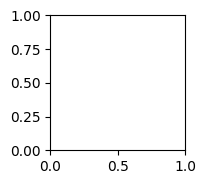

In [161]:
import cv2
from model.model import VideoModel
from utils.helpers import load_missing
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

labels = []
with open('label_sorted.txt') as myfile:
    labels = myfile.read().splitlines()

# Define the desired input shape for the video model
input_shape = (88, 88)  # Adjust the dimensions according to the model's requirements


# video_model = VideoModel(500)
# weight = torch.load("/tf/weights/lrw-cosine-lr-acc-0.85080.pt", map_location=torch.device('cpu'))
# load_missing(video_model, weight.get('video_model'))
# video_model.eval()

# Replace 'filename.mp4' with the path to your video file
# filename = '/tf/single-videos/FOUND_00002.mp4'

def predict(filename, weights_file):
    video_model = VideoModel(500)
    weight = torch.load(weights_file, map_location=torch.device('cpu'))
    load_missing(video_model, weight.get('video_model'))
    video_model.eval()

    # Get the video frames
    raw_frames = extract_opencv(filename)
    # plot_frames(torch.tensor(frames))
    # Preprocess the frames
    frames = preprocess_frames(raw_frames)

    # Access the preprocessed frames tensor
    tensor_frames = frames.squeeze(0)

    # Convert the tensor frames to numpy array
    numpy_frames = tensor_frames.numpy()

    plot_frames(numpy_frames)

    frames = frames.unsqueeze(0)
    predict_classes(video_model, frames)

    # Pass the frames through the model
    with torch.no_grad():
        predictions = video_model(frames)
         # print(f"predictions tensor: {predictions}")
    # Get the predicted label
    predicted_label = torch.argmax(predictions)
    print(predicted_label)

    predicted_label = predicted_label.item()

    # Print the predicted label
    print("file", filename)
    print(f'Predicted label: {predicted_label}')
    print(f'Prediction: {labels[predicted_label]}')

    return labels[predicted_label]

def predict_all_custom_videos(weights_file):
    folder_path = "/tf/single-videos/custom"
    weights_path = "/tf/weights"
    weight_path = os.path.join(weights_path, weights_file)

    predictions_count = 0
    correct_predictions = 0
    for file_name in os.listdir(folder_path):
        actual = file_name.split("_")[0]
        file_path = os.path.join(folder_path, file_name)
        if file_path.endswith(".mp4"):
            predicted = predict(file_path, weight_path)
            predictions_count += 1

            if actual == predicted:
                correct_predictions += 1

            print(f"correct {correct_predictions}/{predictions_count}")

    if predictions_count > 0:
        print("correct:", correct_predictions)
        print("total:", correct_predictions)
        print("acc:", (correct_predictions/predictions_count)*100.0)

def weights_experiment():
    results = {}
    videos_path = "/tf/single-videos/custom"
    weights_path = "/tf/weights"

    predictions_count = 0
    correct_predictions = 0
    for weights_file in os.listdir(weights_path):
        print("testing", weights_file)
        for file_name in os.listdir(videos_path):
            actual = file_name.split("_")[0]
            file_path = os.path.join(videos_path, file_name)
            weight_path = os.path.join(weights_path, weights_file)

            if file_path.endswith(".mp4"):
                predicted = predict(file_path, weight_path)
                predictions_count += 1

                if actual == predicted:
                    correct_predictions += 1

                print(f"correct {correct_predictions}/{predictions_count}")

        if predictions_count > 0:
            print("weights", weights_file)
            print("correct:", correct_predictions)
            print("total:", correct_predictions)

            acc = (correct_predictions/predictions_count)*100.0
            print("acc:", acc)

            results[weights_file] = acc
            print(results)


    print(results)

predict_all_custom_videos("lrw-border-se-mixup-label-smooth-cosine-lr-wd-1e-4-acc-0.88460.pt")